# Creating Shapefiles for Stream Buffers

The purpose of this notebook is to make shapefile buffering at different distances to streams in order to be used in the depth to water and well count notebooks.

To run this file, you will have needed to run 2_NHD_Stream_Preprocessing.ipynb in the DataPreprocessing folder.

In [30]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import time
import gc

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

def log_time(start, message):
    print(f"{message}. Elapsed time: {time.time() - start:.2f}s")

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'


Providing colors

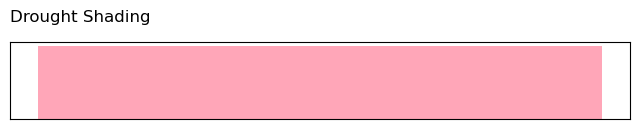

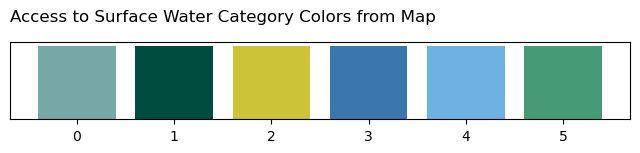

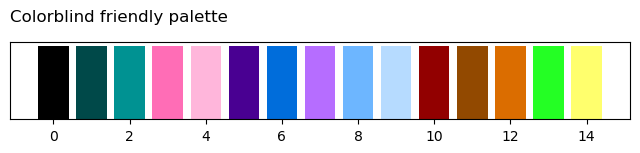

In [15]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

In [16]:
# Put your huc number here
huc_num = '8'

In [18]:
# Read in the reach shapefile

# filename_shapfile = 'georeg_reproject_fixed.shp'
# filename_shapfile = '/flowlines_order4plus.shp'
filename_shapefile = '/huc'+huc_num+'flowlines_order3plus.shp'
# filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapfile)
filepath = os.path.join(outputpath+filename_shapefile)
shapefile = gp.read_file(filepath)
# print(filepath)
# shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [19]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc8,huc_name,fcode,hydroseq,geometry
0,67120165,Tse Bonito Wash,15020006000324,3,NaN,15020006,Upper Puerco,46007,4.000080e+13,"LINESTRING Z (-108.94868 35.67165 0.00000, -10..."
1,67121173,NaN,15020006000758,3,NaN,15020006,Upper Puerco,46007,4.000080e+13,"LINESTRING Z (-108.91989 35.64257 0.00000, -10..."
2,67120427,NaN,15020006000759,3,NaN,15020006,Upper Puerco,46007,4.000080e+13,"LINESTRING Z (-108.91691 35.66162 0.00000, -10..."
3,67120223,NaN,15020006003298,3,NaN,15020006,Upper Puerco,46007,4.000080e+13,"LINESTRING Z (-108.89878 35.67348 0.00000, -10..."
4,67121513,NaN,15020006000758,3,NaN,15020006,Upper Puerco,46007,4.000080e+13,"LINESTRING Z (-108.90904 35.62311 0.00000, -10..."
...,...,...,...,...,...,...,...,...,...,...
295697,79070510,Henrieville Creek,14070007000189,4,09381000,14070007,Paria,46006,4.100010e+13,"LINESTRING Z (-111.97042 37.56902 0.00000, -11..."
295698,79070510,Henrieville Creek,14070007000189,4,373549111545201,14070007,Paria,46006,4.100010e+13,"LINESTRING Z (-111.97042 37.56902 0.00000, -11..."
295699,79070510,Henrieville Creek,14070007000189,4,373549111545201,14070007,Paria,46006,4.100010e+13,"LINESTRING Z (-111.97042 37.56902 0.00000, -11..."
295700,79070656,Little Creek,14070007000191,3,NaN,14070007,Paria,46003,4.100010e+13,"LINESTRING Z (-111.94213 37.56490 0.00000, -11..."


In [21]:
# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""
water_designation = swdom 

Let's only select Rivers/streams and drainageways

<Axes: >

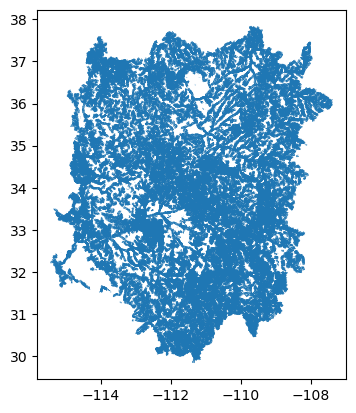

In [23]:
df = shapefile.copy()
df = df[df['fcode']>=46000]
df.plot()

Now let's dissolve by the huc of our choice

In [ ]:
df_dissolved = df.dissolve(by=Naming_col)
df_dissolved = df_dissolved.reset_index()
df_dissolved

,geometry,permanent_,gnis_name,reachcode,streamorde,ID,huc_name,fcode,hydroseq
huc8,,,,,,,,,
14070006,MULTILINESTRING Z ((-110.86955 37.19540 0.0000...,78285038,San Juan River,14080205004922,9,371046111212301,Lower Lake Powell,55800,4.100050e+13
14070007,MULTILINESTRING Z ((-111.60111 36.85910 0.0000...,{C8D40002-8B26-46DC-9E66-1872255CB251},Paria River,15010001017559,7,372526112020201,Paria,46006,4.000050e+13
14080105,MULTILINESTRING Z ((-109.08808 36.56520 0.0000...,103665285,Standing Redrock Creek,14080105001494,4,09367000,Middle San Juan,46003,4.100050e+13
14080106,MULTILINESTRING Z ((-108.92737 36.11658 0.0000...,56539856,Dead Mans Wash,14080106001610,3,09367938,Chaco,46003,4.100050e+13
14080201,MULTILINESTRING Z ((-109.08845 36.97691 0.0000...,75990945,Toh Dahstini Wash,14080201000457,6,371100109200001,Lower San Juan-Four Corners,46003,4.100050e+13
...,...,...,...,...,...,...,...,...,...
15080102,MULTILINESTRING Z ((-112.48597 31.31806 0.0000...,40c4814c-d3cf-4080-b9ae-eb1867d8f6fd,Pia Oik Wash,15080102001297,3,15080102,Rio Sonoyta,46003,4.000010e+13
15080103,MULTILINESTRING Z ((-113.34640 32.15523 0.0000...,137239131,La Jolla Wash,15080103000005,4,15080103,Tule Desert,46007,4.000010e+13
15080200,MULTILINESTRING Z ((-111.47931 31.48803 0.0000...,138849223,Canoa Wash,15080200000022,3,15080200,Rio De La Concepcion,46007,4.000010e+13


Clean up the memory here.

In [ ]:
del shapefile, df

Now we can buffer our stream network.  This can sometime take a while. 

 At 100m it took about 10minutes with plotting, 500m was about 35minutes.

In [35]:
distance = 500 # (meters) Need to change this to 100, 500, 1000, 1500, and 2000

# buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = df_dissolved.copy()
buffered = buffered.to_crs(3857)  # This changes from degrees to meters
# buffered = buffered.buffer(distance)  # Apply buffer
buffered["geometry"] = buffered.geometry.buffer(distance)
# type(buffered)
# buffered.plot()
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp')

Clean up our memory here and then start again

In [36]:
del buffered
gc.collect()

0

In [37]:
distance = 1000 # (meters) Need to change this to 100, 500, 1000, 1500, and 2000

start_time = time.time()

# buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = df_dissolved.copy()
log_time(start_time, "Changing coordinate system...")
buffered = buffered.to_crs(3857)  # This changes from degrees to meters
# buffered = buffered.buffer(distance)  # Apply buffer
log_time(start_time, "Coordinate system changed, initiating buffering...")
buffered["geometry"] = buffered.geometry.buffer(distance)
log_time(start_time, "Buffering complete.  Writing shapefile...")

# type(buffered)
# buffered.plot()
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp')
log_time(start_time, "shapefile written!")


Changing coordinate system.... Elapsed time: 0.00s
Coordinate system changed, initiating buffering.... Elapsed time: 2.84s
Buffering complete.  Writing shapefile.... Elapsed time: 5969.04s
shapefile written!. Elapsed time: 5997.84s


Clean up our memory here and then start again

In [38]:
del buffered
gc.collect()

0

In [39]:
distance = 1500 # (meters) Need to change this to 100, 500, 1000, 1500, and 2000

start_time = time.time()

# buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = df_dissolved.copy()
log_time(start_time, "Changing coordinate system...")
buffered = buffered.to_crs(3857)  # This changes from degrees to meters
# buffered = buffered.buffer(distance)  # Apply buffer
log_time(start_time, "Coordinate system changed, initiating buffering...")
buffered["geometry"] = buffered.geometry.buffer(distance)
log_time(start_time, "Buffering complete.  Writing shapefile...")

# type(buffered)
# buffered.plot()
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp')
log_time(start_time, "shapefile written!")


Changing coordinate system.... Elapsed time: 0.00s
Coordinate system changed, initiating buffering.... Elapsed time: 2.85s
Buffering complete.  Writing shapefile.... Elapsed time: 16237.63s
shapefile written!. Elapsed time: 16252.83s


Clean up our memory here and then start again

In [40]:
del buffered
gc.collect()

0

In [41]:
distance = 2000 # (meters) Need to change this to 100, 500, 1000, 1500, and 2000

start_time = time.time()

# buffered = shapefile.copy()  # Create a copy to avoid modifying the original
buffered = df_dissolved.copy()
log_time(start_time, "Changing coordinate system...")
buffered = buffered.to_crs(3857)  # This changes from degrees to meters
# buffered = buffered.buffer(distance)  # Apply buffer
log_time(start_time, "Coordinate system changed, initiating buffering...")
buffered["geometry"] = buffered.geometry.buffer(distance)
log_time(start_time, "Buffering complete.  Writing shapefile...")

# type(buffered)
# buffered.plot()
# Export the buffered shapefile for creating maps
buffered.to_file(f'{outputpath}/{StudyArea}dissolvedbufferedflowlines_{distance}m.shp')
log_time(start_time, "shapefile written!")


Changing coordinate system.... Elapsed time: 0.00s
Coordinate system changed, initiating buffering.... Elapsed time: 2.82s
Buffering complete.  Writing shapefile.... Elapsed time: 44120.26s
shapefile written!. Elapsed time: 44130.50s


Clean up our memory here and then start again

In [42]:
del buffered
gc.collect()

0